In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def daylight(day, latitude=40):
    """
    This function calculates the number of daylight hours given jullian day of the year, and the latitude.
    For the optwrf work, I have set the default latitude to the 40th parallel since that cuts through
    the center of the domain. 
    """
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos((math.sin(0.8333 * pi / 180) + 
                                                 math.sin(latitude * pi / 180) * math.sin(P)) 
                                                / (math.cos(latitude * pi / 180) * math.cos(P)))
    return daylightamount

In [3]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_050420.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
# Calculate the the normalized number of daylight hours
data['j_date'] = data.start_date.apply(lambda x: x.timetuple().tm_yday)
data['day_len'] = [daylight(data.j_date.iloc[N]) for N in range(len(data.j_date))]
data['day_len_frac'] = data['day_len']/max(data['day_len'])
# Calculate the corrected fitness based upon the day length
data['fitness_corrected'] = data.fitness/data.day_len_frac
data.iloc[:5,:]

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime,season,j_date,day_len,day_len_frac,fitness_corrected
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00,winter,363,9.346323,0.622404,NaN
1,2011-11-27,13,5,7,5,5,14,1,2034.42319,4:39:34.359051,fall,331,9.660898,0.643353,3162.219899
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498,fall,244,13.118862,0.873631,NaN
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799,spring,96,12.838070,0.854932,NaN
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933,spring,122,13.904221,0.925930,NaN


## Principle Component Analysis

In this section, I attempt to apply PCA to determine which physics are the most important. 
However, I have yet to figure out how to do this considering the categorical nature of all of my variables except fitness.

In [4]:
PCA_data = data.drop(['runtime','season'], axis=1) 
PCA_data['start_date'] = data.start_date.apply(lambda x: x.timetuple().tm_yday)
# PCA_data = PCA_data.sort_values(by='fitness')
PCA_data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,j_date,day_len,day_len_frac,fitness_corrected
0,363,2,31,2,3,5,93,1,NaN,363,9.346323,0.622404,NaN
1,331,13,5,7,5,5,14,1,2034.423190,331,9.660898,0.643353,3162.219899
2,244,14,4,7,1,1,11,2,NaN,244,13.118862,0.873631,NaN
3,96,18,1,5,7,9,16,1,NaN,96,12.838070,0.854932,NaN
4,122,14,7,1,7,8,94,1,NaN,122,13.904221,0.925930,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,363,4,99,24,4,7,3,1,636.979945,363,9.346323,0.622404,1023.418484
1119,117,5,99,1,4,7,6,1,1494.732208,117,13.711911,0.913124,1636.943476
1120,84,4,99,99,4,7,6,1,777.975892,84,12.312584,0.819938,948.823007
1121,110,10,1,24,1,12,3,1,1165.439926,110,13.430486,0.894383,1303.066122


In [5]:
features = ['start_date', 'mp_physics', 'ra_lw_physics', 'ra_sw_physics', 'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 'sf_sfclay_physics']
# Separating out the features
x = PCA_data.loc[:, features].values
# Separating out the target
y = PCA_data.loc[:,['fitness']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [6]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'])
pca.explained_variance_ratio_

array([0.20774531, 0.15408556, 0.13604282, 0.12923736, 0.11508092])

In [7]:
finalDf = pd.concat([principalDf, PCA_data[['start_date', 'mp_physics', 'ra_lw_physics', 'ra_sw_physics', 'sf_surface_physics', 'bl_pbl_physics', 'cu_physics', 'sf_sfclay_physics','fitness']]], axis = 1)
finalDf

,PC 1,PC 2,PC 3,PC 4,PC 5,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness
0,-0.478528,-0.895174,0.814241,-1.687054,0.632794,363,2,31,2,3,5,93,1,NaN
1,0.140303,0.130064,0.325741,-1.306328,0.623228,331,13,5,7,5,5,14,1,2034.423190
2,1.677525,0.541768,0.730621,-1.202464,-0.641868,244,14,4,7,1,1,11,2,NaN
3,-0.820826,0.708443,0.147836,0.603763,-0.334994,96,18,1,5,7,9,16,1,NaN
4,-1.884669,0.547290,1.046815,0.184366,-0.210543,122,14,7,1,7,8,94,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,1.470845,-1.597925,0.374383,-0.888028,1.593216,363,4,99,24,4,7,3,1,636.979945
1119,1.117170,-1.539695,0.977992,0.398702,-0.338813,117,5,99,1,4,7,6,1,1494.732208
1120,2.199373,-0.494878,0.620902,2.822429,2.185724,84,4,99,99,4,7,6,1,777.975892
1121,0.537135,-0.111637,-1.965983,0.985012,-0.644490,110,10,1,24,1,12,3,1,1165.439926


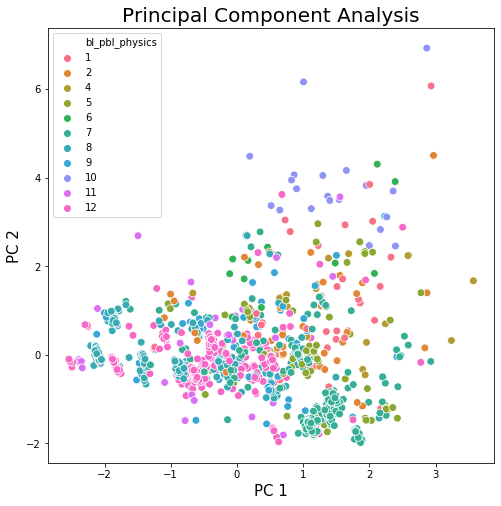

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Principal Component Analysis', fontsize = 20)
n_colors = finalDf['bl_pbl_physics'].nunique()
sns.scatterplot(finalDf.loc[:,'PC 1'], finalDf.loc[:,'PC 2'], 
                hue=finalDf.bl_pbl_physics, palette=sns.husl_palette(n_colors), s=60)
